In [56]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 1220

In [57]:
data_path_local = './toxic_comments.csv'
data_path_web = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(data_path_local):
    df = pd.read_csv(data_path_local, index_col=[0], parse_dates=[0])
elif requests.head(data_path_web).status_code == 200:
    df = pd.read_csv(data_path_web, index_col=[0], parse_dates=[0])
else:
    print('Somthing is wrong')

In [58]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


In [59]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [60]:
df.isnull().sum()

text     0
toxic    0
dtype: int64

In [61]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

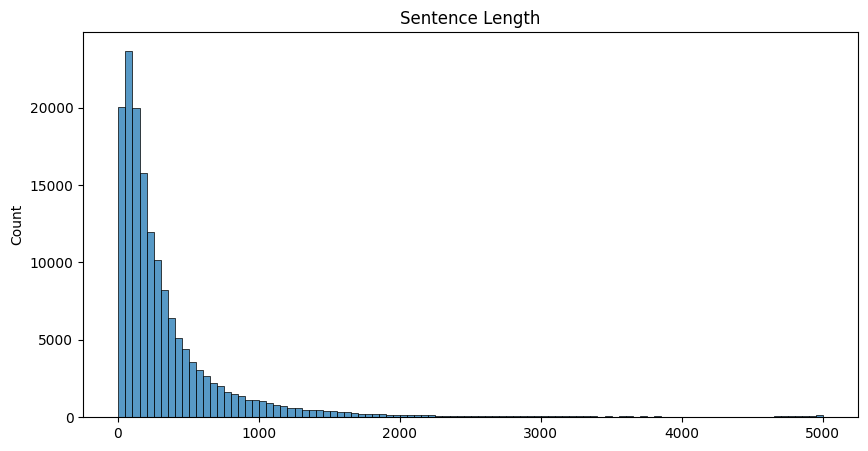

In [62]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [63]:
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

Max length:  5000


In [64]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                   df['toxic'].values,
                                                   test_size = 0.15,
                                                   random_state = RANDOM_STATE,
                                                   stratify = df['toxic'].values)

In [65]:
df['data_type'] = ['not_set'] * df.shape[0]
df.head()

,text,toxic,data_type
0,Explanation\nWhy the edits made under my usern...,0,not_set
1,D'aww! He matches this background colour I'm s...,0,not_set
2,"Hey man, I'm really not trying to edit war. It...",0,not_set
3,"""\nMore\nI can't make any real suggestions on ...",0,not_set
4,"You, sir, are my hero. Any chance you remember...",0,not_set


In [66]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [67]:
df.groupby(['toxic', 'data_type']).count()

text
toxic data_type        
0     train      121640
      val         21466
1     train       13758
      val          2428

In [68]:
! pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [69]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [91]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [92]:
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [93]:
encoded_data_train

{'input_ids': tensor([[  101,  7526,  2339,  ...,     0,     0,     0],
        [  101,  4931,  2158,  ...,     0,     0,     0],
        [  101,  1000,  2062,  ...,     0,     0,     0],
        ...,
        [  101, 13183,  6290,  ...,     0,     0,     0],
        [  101,  1998,  2009,  ...,     0,     0,     0],
        [  101,  1000,  1998,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [94]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].toxic.values)

In [95]:
#encode val set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

#convert data type to torch.tensor
labels_val = torch.tensor(df[df.data_type == 'val'].toxic.values)

In [96]:
input_ids_train

tensor([[  101,  7526,  2339,  ...,     0,     0,     0],
        [  101,  4931,  2158,  ...,     0,     0,     0],
        [  101,  1000,  2062,  ...,     0,     0,     0],
        ...,
        [  101, 13183,  6290,  ...,     0,     0,     0],
        [  101,  1998,  2009,  ...,     0,     0,     0],
        [  101,  1000,  1998,  ...,     0,     0,     0]])

In [97]:
attention_masks_train

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [98]:
labels_train

tensor([0, 0, 0,  ..., 0, 0, 0])

In [99]:
#create dataloader
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [100]:
print(len(dataset_train))
print(len(dataset_val))

135398
23894


In [101]:
dataset_train

In [102]:
dataset_train.tensors

(tensor([[  101,  7526,  2339,  ...,     0,     0,     0],
         [  101,  4931,  2158,  ...,     0,     0,     0],
         [  101,  1000,  2062,  ...,     0,     0,     0],
         ...,
         [  101, 13183,  6290,  ...,     0,     0,     0],
         [  101,  1998,  2009,  ...,     0,     0,     0],
         [  101,  1000,  1998,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [103]:
from transformers import BertForSequenceClassification

#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [105]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 #since we have limited resource

#load train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#load val set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step

In [106]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

#load optimizer
optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5

In [107]:
#load scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

In [108]:
import numpy as np
from sklearn.metrics import f1_score

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [109]:
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in {'0':0, '1':1}}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [110]:
torch.cuda.is_available()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(dataloader_val):

    #evaluation mode disables the dropout layer 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(DEVICE) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [111]:
import random

seed_val = RANDOM_STATE
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [112]:
for epoch in tqdm(range(1, epochs+1)):

    #set model in train mode
    model.train()

    #tracking variable
    loss_train_total = 0
    
    #set up progress bar
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        #set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(DEVICE) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()
        
        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    tqdm.write('\nEpoch {epoch}')
    
    #print training result
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    #evaluate
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    #f1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33850 [00:00<?, ?it/s]